In [3]:

from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator


# Initialize the Qiskit IBM Runtime service
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    # token='982f334665888fce1313aa2ecd74553e806eb521197f2332e28a368cfdc779e26a8b0df921b82798fbd23eb0228773e8edf685994e4779b516622f026c2fefb7'
    token= 'dd810d4274a18946b6783e5557a9e2a912c07a2dd722153fd10e5dd5fa7512521eb33cad123947c69ff02debf01e4615b67460fbb51fd94cb2f2b6153d5401d9'
)

In [2]:
from qiskit.circuit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passmanager import PassManager

from qiskit_ibm_runtime.transpiler.passes.scheduling import DynamicCircuitInstructionDurations
from qiskit_ibm_runtime.transpiler.passes.scheduling import ALAPScheduleAnalysis
from qiskit_ibm_runtime.transpiler.passes.scheduling import PadDelay

backend = service.least_busy(operational=True, simulator=False)

# Use this duration class to get appropriate durations for dynamic
# circuit backend scheduling
durations = DynamicCircuitInstructionDurations.from_backend(backend)
# Generate the main Qiskit transpile passes.
pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
# Configure the as-late-as-possible scheduling pass
pm.scheduling = PassManager([ALAPScheduleAnalysis(durations), PadDelay(durations)])

qr = QuantumRegister(1)

qc = QuantumCircuit(qr)

qc.sx(qr[0])
qc.delay(100, qr[0])

# Transpile.
scheduled_teleport = pm.run(qc)

# scheduled_teleport.draw(output="mpl", style="iqp")

In [3]:


# dd_sequence = [XGate(), XGate()]

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(durations)
    ]
)

qc_schedualed = pm.run(qc)

# dd_teleport.draw(output="mpl", style="iqp")

In [4]:
# Initialize estimator
estimator = Estimator(mode=backend)

observable_str = "X"
observable = SparsePauliOp(observable_str)
isa_observable = observable.apply_layout(qc.layout)

# Run estimation
job = estimator.run([(qc, isa_observable, [])])

print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")
result = job.result()
print(f"  > Expectation value: {result[0].data.evs}")
print(f"  > Metadata: {result[0].metadata}")


>>> Job ID: cz058vv5k0xg0088m8bg
>>> Job Status: QUEUED
  > Expectation value: -0.0044204322200392925
  > Metadata: {'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32}


TranspilerError: 'The input circuit None is not scheduled. Call one of scheduling passes before running the ConstrainedReschedule pass.'

In [7]:

# 1. Build the quantum circuit with a Hadamard and a delay
qc = QuantumCircuit(1, 1)  # 1 qubit, 1 classical bit
qc.h(0)  # Apply Hadamard on qubit 0
qc.delay(100, 0, unit="dt")  # Insert a delay of 100 dt on qubit 0
qc.measure(0, 0)  # Measure qubit 0

print("Original circuit:")
print(qc)

# 2. Transpile the circuit to the backend’s native gate set
qc_transpiled = transpile(qc, backend=backend)
print("\nTranspiled circuit:")
print(qc_transpiled)

# 3. Execute the transpiled circuit on the backend
job = backend.run(qc_transpiled, shots=1024)
result = job.result()
print("\nMeasurement counts:", result.get_counts())

Original circuit:
     ┌───┐┌────────────────┐┌─┐
  q: ┤ H ├┤ Delay(100[dt]) ├┤M├
     └───┘└────────────────┘└╥┘
c: 1/════════════════════════╩═
                             0 


TranspilerError: 'The input circuit None is not scheduled. Call one of scheduling passes before running the ConstrainedReschedule pass.'

In [8]:
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, random_hermitian
from qiskit_ibm_runtime import EstimatorV2 as Estimator

n_qubits = 50

backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=n_qubits
)

mat = np.real(random_hermitian(n_qubits, seed=1234))
circuit = IQP(mat)
observable = SparsePauliOp("Z" * 50)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)

estimator = Estimator(mode=backend)
job = estimator.run([(isa_circuit, isa_observable)])
result = job.result()

print(f" > Expectation value: {result[0].data.evs}")
print(f" > Metadata: {result[0].metadata}")

 > Expectation value: 0.14035087719298245
 > Metadata: {'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32}


In [104]:
import numpy as np
import qiskit
from qiskit_experiments.library import T2Ramsey

backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=1
)

qubit = 0
delays = list(np.arange(1e-6, 30-6, 2e-6))
exp1 = T2Ramsey((qubit,), delays, osc_freq=0)
exp1.set_transpile_options(scheduling_method='asap', optimization_level=0)
expdata1 = exp1.run(backend=backend, shots=500)
expdata1.block_for_results()  # Wait for job/analysis to finish.
display(expdata1.figure(0))


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

In [51]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.circuit import QuantumCircuit, QuantumRegister
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_experiments.framework import BackendTiming
import numpy as np

# backend = service.least_busy(operational=True, simulator=False, min_num_qubits=1)
backend = service.backend("ibm_sherbrooke")
timing = BackendTiming(backend)

delays = list(np.arange(0, 60e-6, 1e-6))
twice = delays.copy()
twice.extend(delays)
# delays = [3e-6]
circuits = []
layout = [1,2]
for i, delay in enumerate(twice):
    circ = QuantumCircuit(2, 2)
    #hadamard
    circ.rz(np.pi, 0)
    circ.sx(0)
    circ.rz(np.pi, 0)

    if i > len(delays):
        circ.x(1)
    circ.barrier()


    circ.delay(timing.round_delay(time=delay), 0, timing.delay_unit)
    circ.delay(timing.round_delay(time=delay), 1, timing.delay_unit)

    circ.barrier()
    # circ.x(1)

    #hadamard
    circ.rz(np.pi, 0)
    circ.sx(0)
    circ.rz(np.pi, 0)

    circ.metadata = {"xval": timing.delay_time(time=delay)}

    circuits.append(circ)

# job_circuits = [circuits]
# transpiled = transpile(circuits, backend=backend)
# sampler = Sampler(backend)
# jobs = [sampler.run(circs) for circs in job_circuits]


pubs = []
observable = SparsePauliOp("IZ")
pm = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=layout)
for qc in circuits:
    isa_circuit = pm.run(qc)
    isa_obs = observable.apply_layout(isa_circuit.layout)
    pubs.append((isa_circuit, isa_obs))

estimator = Estimator(backend, options={"default_shots": int(1e4)})
job = estimator.run(pubs)
job_result = job.result()

C:\Users\david\PycharmProjects\Crosstalk\.venv\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:857: UserWarning: Your current pending jobs are estimated to consume 320.12400000000076 quantum seconds, but you only have 253 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


In [53]:

print(len(circuits))
print(len(pubs))
for idx in range(len(pubs)):
    pub_result = job_result[idx]
    print(f">>> Expectation values for PUB {idx}: {pub_result.data.evs}")
    print(f">>> Standard errors for PUB {idx}: {pub_result.data.stds}")


expt = [pub_result.data.evs for pub_result in job_result]
expt_nocross = expt[:len(delays)]
expt_cross = expt[len(delays):]

122
122
>>> Expectation values for PUB 0: -0.9601241630961521
>>> Standard errors for PUB 0: 0.006648629521630007
>>> Expectation values for PUB 1: -0.9711139179896146
>>> Standard errors for PUB 1: 0.006219952991166112
>>> Expectation values for PUB 2: -0.9556859928507153
>>> Standard errors for PUB 2: 0.006656041727510938
>>> Expectation values for PUB 3: -0.9472323352403597
>>> Standard errors for PUB 3: 0.00613096761076807
>>> Expectation values for PUB 4: -0.9307477029001658
>>> Standard errors for PUB 4: 0.006966736638813604
>>> Expectation values for PUB 5: -0.9180672164846323
>>> Standard errors for PUB 5: 0.00644235815329001
>>> Expectation values for PUB 6: -0.8960877066977074
>>> Standard errors for PUB 6: 0.008352530984295241
>>> Expectation values for PUB 7: -0.8783350257159603
>>> Standard errors for PUB 7: 0.006364367254507898
>>> Expectation values for PUB 8: -0.8489585655199742
>>> Standard errors for PUB 8: 0.007098565851764727
>>> Expectation values for PUB 9: -0.820

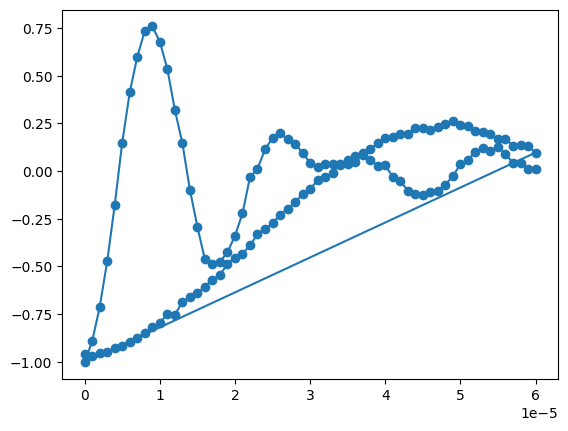

In [54]:
import matplotlib.pyplot as plt
plt.plot(twice, expt, 'o-')

In [119]:
import estimator
import numpy as np
import Ramsey_ExperimentV3
expt_array = np.array(expt)

# scaled_expt = (expt_array - np.min(expt_array)) / (np.max(expt_array) - np.min(expt_array)) * np.pi
# modif_expt =[[-1*expt_array[i]] for i in range(len(expt_array))]

scaled_delay = (delays - np.min(delays)) / (np.max(delays) - np.min(delays)) * 1.5*np.pi
expt_nocross_modif = [[-1*expt_nocross[i]] for i in range(len(expt_nocross))]
expt_cross_modif = [[-1*expt_cross[i]] for i in range(len(expt_cross))]
batch_nocross = Ramsey_ExperimentV3.package_data([expt_nocross_modif], 1, 1000*8, scaled_delay, [], {}, [], [],[],[])[0]
batch_cross = Ramsey_ExperimentV3.package_data([expt_cross_modif], 1, 1000*8, scaled_delay, [], {}, [], [],[],[])[0]


In [120]:
D,W,J = estimator.one_by_one_X(batch_nocross, batch_nocross)
D_cross,W_cross,J_cross = estimator.one_by_one_X(batch_cross, batch_cross)

print(D,W,J)
print(D_cross,W_cross,J_cross)

[0.26535673] [0.57636441] []
[0.761699] [4.40849511] []


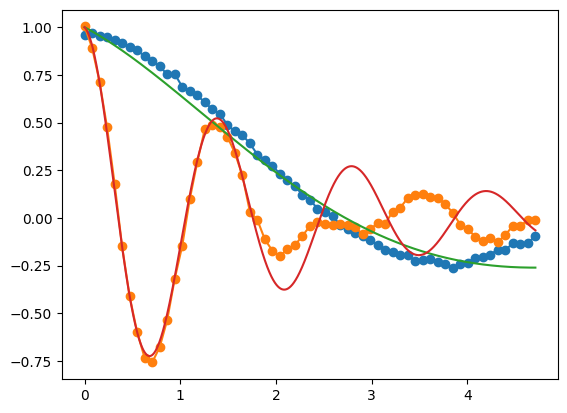

In [128]:
# W = 0.85
# D = 0.7
# D_cross = 0.7
highres_delay = np.arange(0, 1.5*np.pi, 0.001)
plt.plot(scaled_delay, expt_nocross_modif, 'o-')
plt.plot(scaled_delay, expt_cross_modif, 'o-')

# plt.plot(scaled_delay, cross, 'o-')
# plt.plot(short_delay, short_expt, 'o-')
plt.plot(highres_delay, [np.cos(W*d)*np.exp(-D*d) for d in highres_delay])
plt.plot(highres_delay, [np.cos(6.7/1.5*d)*np.exp(-D_cross*d) for d in highres_delay])

[0.46579315] [4.44511512] []


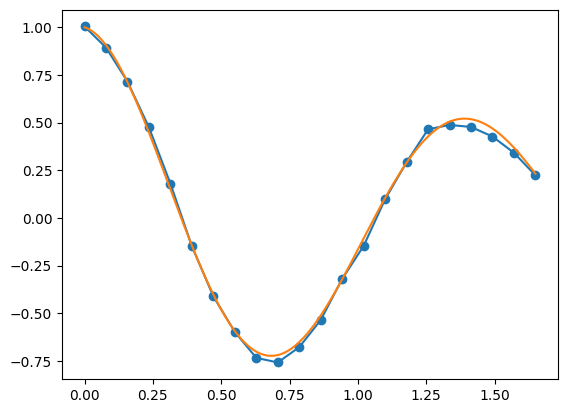

In [127]:
n = 22
truncated_cross = expt_cross_modif[:n]
truncated_delay = scaled_delay[:n]
highres_delay = np.arange(0, truncated_delay[-1], 0.001)
batch_cross = Ramsey_ExperimentV3.package_data([truncated_cross], 1, 1000*8, truncated_delay, [], {}, [], [],[],[])[0]
D_cross,W_cross,J_cross = estimator.one_by_one_X(batch_cross, batch_cross)
print(D_cross,W_cross,J_cross)
plt.plot(truncated_delay, truncated_cross, 'o-')
plt.plot(highres_delay, [np.cos(W_cross*d)*np.exp(-D_cross*d) for d in highres_delay])

In [ ]:
# no_cross =

In [28]:
# cross = modif_expt

In [34]:
delays = list(np.arange(0, 100e-6, 3e-6))
delays.extend(delays)
print(delays)

[0.0, 3e-06, 6e-06, 9e-06, 1.2e-05, 1.5e-05, 1.8e-05, 2.1000000000000002e-05, 2.4e-05, 2.7e-05, 3e-05, 3.3e-05, 3.6e-05, 3.9e-05, 4.2000000000000004e-05, 4.5e-05, 4.8e-05, 5.1e-05, 5.4e-05, 5.7e-05, 6e-05, 6.3e-05, 6.6e-05, 6.9e-05, 7.2e-05, 7.500000000000001e-05, 7.8e-05, 8.1e-05, 8.400000000000001e-05, 8.7e-05, 9e-05, 9.3e-05, 9.6e-05, 9.900000000000001e-05, 0.0, 3e-06, 6e-06, 9e-06, 1.2e-05, 1.5e-05, 1.8e-05, 2.1000000000000002e-05, 2.4e-05, 2.7e-05, 3e-05, 3.3e-05, 3.6e-05, 3.9e-05, 4.2000000000000004e-05, 4.5e-05, 4.8e-05, 5.1e-05, 5.4e-05, 5.7e-05, 6e-05, 6.3e-05, 6.6e-05, 6.9e-05, 7.2e-05, 7.500000000000001e-05, 7.8e-05, 8.1e-05, 8.400000000000001e-05, 8.7e-05, 9e-05, 9.3e-05, 9.6e-05, 9.900000000000001e-05]
